# Preparing the Data

We first start off by understanding the different data we are provided, and take a look into the bits and pieces that we will need from the data and give things a bit more structure.

### Preface

Starting off the project, we were given large JSON files and a Python script to download said large files and work with. So, I had to think about how I would manipulate the data in a manner that would save time and not incurr huge processing/memory penalties. 

The first step was to deal with random metadata and arbitrary information within these files and strip them off to make life easier.

I would've done this in Python, but thankfully, the good folks at Riot gave us Athena Ready™ scripts that we can use to query (the significantly more) compressed data, directly from the S3 bucket without downloading files. 

So with the crawler setup and the tables loaded, I decided to sift through data within using SQL and AWS Athena explorer, and leveraged queries that reduced the data to the parts we are most interested in to create a methodology to generate team rankings.

The reduced data could then be downloaded as CSVs and read into Data Science tools for ease of use.

CSV is already quite good in terms of storage, but I've taken the liberty to convert certain large files from either JSON or CSV to [parquet](https://www.databricks.com/glossary/what-is-parquet) to save storage space.

## Leagues

The following SQL statement gives us a new leagues file with some of the redundant columns like `displayPriority`, `sport`, `image` etc. dropped

```sql
SELECT id, name, slug, region, tournaments FROM "lol"."leagues"
```

All in all, it seems that we have tournament data for 38 leagues hosted across the world.

In [348]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

leagues_df = pd.read_csv("../esports-data/leagues.csv")

In [2]:
leagues_df.head(5)

,id,name,slug,region,tournaments
0,98767991299243165,LCS,lcs,NORTH AMERICA,"[{id=110303581083678395}, {id=1095170900666056..."
1,109511549831443335,LCS Challengers,north_american_challenger_league,NORTH AMERICA,"[{id=110574243270525539}, {id=1095186976607462..."
2,109518549825754242,LCS Challengers Qualifiers,lcs_challengers_qualifiers,NORTH AMERICA,"[{id=110894544221659776}, {id=1107338389351362..."
3,107898214974993351,College Championship,college_championship,NORTH AMERICA,[{id=107898708099217418}]
4,98767991332355509,CBLOL,cblol-brazil,BRAZIL,"[{id=110413046183015975}, {id=1095236414167506..."


In [3]:
leagues_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           38 non-null     int64 
 1   name         38 non-null     object
 2   slug         38 non-null     object
 3   region       38 non-null     object
 4   tournaments  38 non-null     object
dtypes: int64(1), object(4)
memory usage: 1.6+ KB


#### All available leagues

In [4]:
league_name_df = pd.DataFrame({"name": leagues_df.name, "region": leagues_df.region}, columns=["name", "region"])
league_name_df

,name,region
0,LCS,NORTH AMERICA
1,LCS Challengers,NORTH AMERICA
2,LCS Challengers Qualifiers,NORTH AMERICA
3,College Championship,NORTH AMERICA
4,CBLOL,BRAZIL
5,LCK,KOREA
6,LCL,COMMONWEALTH OF INDEPENDENT STATES
7,LCO,OCEANIA
8,LEC,EMEA
9,LJL,JAPAN


## Players & Teams

Looking into the players and teams data we notice that the players file has a `home_team_id` field for the player, while the teams data comes with `team_id` which this directly maps to.

The following query on Athena creates a mapping of every player to every team:

```sql
select distinct team_id as "teamId", name, acronym, slug, player_id as "playerId", handle, first_name, last_name
from lol."players" join lol."teams"
on team_id = home_team_id
```

We are not omitting anything here since we might want to leverage all the data here to build out some kind of nice front-end to deliver the results (time permitting). This created a CSV file which I downloaded and then converted to `parquet` for a smaller file footprint.

In [6]:
teams_and_players_df = pd.read_parquet("../esports-data/distinct_team_player_mapping.parquet")
teams_and_players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2618 entries, 0 to 2617
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   team_id     2618 non-null   int64 
 1   name        2618 non-null   object
 2   acronym     2618 non-null   object
 3   slug        2618 non-null   object
 4   player_id   2618 non-null   int64 
 5   handle      2618 non-null   object
 6   first_name  2618 non-null   object
 7   last_name   2618 non-null   object
dtypes: int64(2), object(6)
memory usage: 163.8+ KB


In [7]:
print("Number of teams total: ", len(teams_and_players_df.name.unique()))
teams_and_players_df.head(5)

Number of teams total:  501


,team_id,name,acronym,slug,player_id,handle,first_name,last_name
0,105505619546859895,OKSavingsBank BRION,BRO,fredit-brion,99566404525897139,UmTi,Sunghyeon,Um
1,106827823550343961,AXZ Academy,AXZ,axz-academy,110536783764146522,kentakki,Kenta,Saito
2,98767991949608898,Fenerbahçe Espor,FB,fenerbahce-espor,99566404559755136,SeongHwan,Yun,Seong Hwan
3,109642680932009857,Nord Esports,NORD,nord-esports,110428375437150775,Hid0,Gian Miguel,Caruana
4,110534712174898632,Blue Otter,BOL,blue-otter,109800032657915058,Zev,Mark,Villaneuva


An immediate problem is posed since these aren't just mappings of the starting roster for the team to players, but also include subs and other members. For instance, Nukeduck is now a coach for 100T who was a former sub as a midlaner and is not part of the active roster in "playing" terms. 

So we need to keep this in mind before we proceed further and may have to leverage mapping data as source of truth for exact player information for those who "played" in the game vs players who are subs and coaches, if we are to extract game events for particular players to create a rating for the players themselves.

In [8]:
teams_with_more_than_5_players = teams_and_players_df.groupby('team_id').filter(lambda x: len(x) > 5)
print("Number of teams with more than 5 players: ", len(teams_with_more_than_5_players.name.unique()))
teams_with_more_than_5_players.sort_values(by=['name']).head(15)

Number of teams with more than 5 players:  230


,team_id,name,acronym,slug,player_id,handle,first_name,last_name
1325,99294153828264740,100 Thieves,100,100-thieves,98926509785257793,Ssumday,Chanho,Kim
59,99294153828264740,100 Thieves,100,100-thieves,99603798169593745,Closer,Can,Çelik
715,99294153828264740,100 Thieves,100,100-thieves,99322214616775017,Nukeduck,Erlend,Holm
2268,99294153828264740,100 Thieves,100,100-thieves,107569568015156338,Sniper,Rayan,Shoura
750,99294153828264740,100 Thieves,100,100-thieves,98767991769705572,Doublelift,Yiliang,Peng
451,99294153828264740,100 Thieves,100,100-thieves,107492071007218117,Quid,HYEONSEUNG,Lim
832,99294153828264740,100 Thieves,100,100-thieves,106625308523122120,Busio,Alan,Cwalina
2398,99294153828264740,100 Thieves,100,100-thieves,104559243245199489,Tenacity,Milan,Oleksij
738,109696138543579708,3BL Esports,3BL,ebl-esports,99682959194260565,Chosen,Yunus,Baş
2292,109696138543579708,3BL Esports,3BL,ebl-esports,109721399266584404,Meza,Hamza,El Barqoqi


## Mapping Data

Next, we need to look at the mapping data for the above since this is where things start to get interesting.

Here's the SQL to gather the info:

```sql
SELECT DISTINCT esportsgameid as "esports_game_id", platformgameid as "platform_game_id", teammapping as "team_mapping", participantmapping as "participant_mapping" FROM "lol"."mapping_data";
```

For this data, I converted the JSON to parquet for a size reduction from 16.2MB to ~900KB. 

In [8]:
mapping_df = pd.read_parquet("../esports-data/mapping_data.parquet")

In [9]:
mapping_df.head(5)

,esportsGameId,platformGameId,teamMapping,participantMapping
0,110378429158160384,ESPORTSTMNT01:3416295,"{'100': '105550033967461806', '200': '10555002...","{'1': '108205130568869560', '10': '11073024065..."
1,110471139171602608,ESPORTSTMNT02:3228341,"{'100': '109485335453835911', '200': '10555000...","{'1': '103478281338008082', '10': '10539723866..."
2,110535609417029696,ESPORTSTMNT04:2693199,"{'100': '109696092218588987', '200': '10835230...","{'1': '109696535754261145', '10': '10756442829..."
3,110847390580148352,ESPORTSTMNT01:3413275,"{'100': '107700204561086446', '200': '99566406...","{'1': '99566406483827119', '10': '101383792831..."
4,110413246204026224,ESPORTSTMNT01:3412587,"{'100': '109485335453835911', '200': '10555000...","{'1': '103478281338008082', '10': '10374359384..."


In [10]:
len(mapping_df)
mapping_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25283 entries, 0 to 25282
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   esportsGameId       25283 non-null  int64 
 1   platformGameId      25283 non-null  object
 2   teamMapping         25283 non-null  object
 3   participantMapping  25283 non-null  object
dtypes: int64(1), object(3)
memory usage: 790.2+ KB


There's about 25,283 games, but there are a few key things we already want to start doing with this mapping data that maps to the `game` with respect to the teams.

First, we want to be able to identity games where information is complete. Our ML model would need as much data as possible and ensuring that we don't run into missing information is key to training and validating the model.

Let's try to find any missing data. 

For starters, we want to turn those nested objects into a flatter structure such that we can start analyzing how much missing data we actually have, and how much of that can we fill

In [11]:
# Flatten the 'teamMapping' and 'participantMapping' columns
flattened_df = pd.concat([
    mapping_df.drop(['teamMapping', 'participantMapping'], axis=1),
    mapping_df['teamMapping'].apply(pd.Series),
    mapping_df['participantMapping'].apply(pd.Series).add_prefix('participant_')
], axis=1)

flattened_df.head()

,esportsGameId,platformGameId,100,200,participant_1,participant_10,participant_2,participant_3,participant_4,participant_5,participant_6,participant_7,participant_8,participant_9
0,110378429158160384,ESPORTSTMNT01:3416295,105550033967461806,105550026570060790,108205130568869560,110730240651882119,108366332471078988,107492116585043595,102483272156027229,105388980252039870,105501816646382923,106267599829820917,107492063150003806,106267600924403194
1,110471139171602608,ESPORTSTMNT02:3228341,109485335453835911,105550005698683818,103478281338008082,105397238669368241,103478281341350420,107560281476330464,101383793082615993,107559633217576287,105397207118950800,109519057410044019,103461966873003900,109519061710277829
2,110535609417029696,ESPORTSTMNT04:2693199,109696092218588987,108352305932141947,109696535754261145,107564428297402857,99566406317824602,105536902415377888,109696576870241602,109696579630268337,109705412728201213,105548731617719496,103963733877026827,105548605376090785
3,110847390580148352,ESPORTSTMNT01:3413275,107700204561086446,99566406332987990,99566406483827119,101383792831678607,99566406443271739,98767991808793901,107705431471339985,109642948838393879,100160799381721105,104668539132702977,105709404500072628,99566406296347493
4,110413246204026224,ESPORTSTMNT01:3412587,109485335453835911,105550001032913831,103478281338008082,103743593842085398,103478281341350420,107560281476330464,101383793082615993,107559633217576287,107559597273805278,110434822594728434,103980682928812378,108395451349202875


In [12]:
# Check for missing values in the flattened DataFrame
missing_values_df = flattened_df.isnull().sum()

# Filter columns with missing values
columns_with_missing_values = missing_values_df[missing_values_df > 0]

columns_with_missing_values

100                 17
200                 19
participant_1      951
participant_10     990
participant_2      987
participant_3      935
participant_4     1008
participant_5      998
participant_6      933
participant_7      983
participant_8      935
participant_9     1008
dtype: int64

In [13]:
# Count the number of rows with any missing values
rows_with_missing_values = flattened_df.isnull().any(axis=1).sum()
rows_with_missing_values

1569

For now, let's just filter out rows with missing values since we might need to do additional data gathering to figure out which players are subs, and which are part of the playing roster within games. Dropping 1569 games for the time being is not an issue.

In [14]:
# Filter out rows with any missing values
filtered_df = flattened_df.dropna(subset=["100", "200"] + [f"participant_{i}" for i in range(1, 11)])
len(filtered_df)

23714

In [15]:
# UNCOMMENT BELOW TO SAVE OUTPUT AND BACKUP
# filtered_df.to_parquet('../esports-data/filtered-mapping-data.parquet')

## Tournaments Mapping

The tournaments mapping data is a bit convoluted since there's large nested objects within the `stages` column. We will need to break this down to see what's going on inside those objects...

This JSON data was 91.1MB and parquet takes it down to ~1.1MB.

Some caveats I've collected from various resource docs and discord answers (and questions to think about):
- Riot is only providing esports mappings and game data for LPL Summer 2023
    - Q: What methodology to use for determining rankings for past data where game data isn't available?
    - Need to analyze older games first and create estimates for what are the win conditions for a team based on available data
- programs should be able to handle not finding an associated platform ID for a given esports ID
- in tournaments file, for each esports match listed there is a team field with players - these are the players listed for a given team roster at the time that the game was mapped and will also include subs - this does not mean all those players have played in the match
    - Need to check if player played in the game -> if role is none, it's a sub

In [187]:
tournaments_df = pd.read_parquet("../esports-data/tournaments.parquet")
tournaments_df.sort_values(by=["startDate"]).head()

,id,leagueId,name,slug,sport,startDate,endDate,stages
243,103462439438682784,98767991299243168,LCS Spring 2020,lcs_spring_2020,lol,2020-01-24,2020-04-20,"[{'name': 'Regular Season', 'sections': [{'mat..."
83,103462459318635408,98767991302996016,LEC Spring 2020,lec_spring_2020,lol,2020-01-24,2020-04-27,"[{'name': 'Regular Season', 'sections': [{'mat..."
198,103462454280724880,99332500638116288,LCS Academy Spring 2020,lcs_academy_spring_2020,lol,2020-01-24,2020-04-20,"[{'name': 'Regular Season', 'sections': [{'mat..."
50,103478354329449184,98767991332355504,CBLOL 2020 Split 1,cblol_2020_split1,lol,2020-01-25,2020-05-03,"[{'name': 'Regular Season', 'sections': [{'mat..."
36,103535401218775280,98767991331560960,OPL 2020 Split 1,opl_2020_split1,lol,2020-01-31,2020-04-24,"[{'name': 'Regular Season', 'sections': [{'mat..."


In [188]:
print(f"We have access to {len(tournaments_df)} tournaments")

We have access to 248 tournaments


For the 248 tournaments, it's important to see how the nested `stages` structure looks. It's a very complex nested structure, so we will need some elbow grease to start parsing out the relevant information we are looking for our algorithm to calculate team rankings.

The complex nesting makes this highly suitable for AWS Athena where a lot of this work is being cross-checked with to ensure consistent outputs.

In [280]:
exploded_stages = tournaments_df['stages'].explode()
exploded_stages

0      {'name': 'Groups', 'sections': [{'matches': [{...
0      {'name': 'knockouts', 'sections': [{'matches':...
1      {'name': 'Regular Season', 'sections': [{'matc...
1      {'name': 'Playoffs', 'sections': [{'matches': ...
2      {'name': 'Regular Season', 'sections': [{'matc...
                             ...                        
245    {'name': 'west', 'sections': [{'matches': [{'g...
246    {'name': 'Regular Season', 'sections': [{'matc...
246    {'name': 'Playoffs', 'sections': [{'matches': ...
247    {'name': 'Regular Season', 'sections': [{'matc...
247    {'name': 'Playoffs', 'sections': [{'matches': ...
Name: stages, Length: 507, dtype: object

In [281]:
stage_names = set()
for i, v in enumerate(exploded_stages):
    stage_names.add(v['name'])

print(f"Num stage names: {len(stage_names)}")
stage_names

Num stage names: 18


{'Bracket Stage',
 'Groups',
 'Knockouts',
 'Play In Groups',
 'Play In Knockouts',
 'Playoffs',
 'Promotion Series',
 'Regional Finals',
 'Regional Qualifier',
 'Regular Season',
 'Round 1',
 'Round 2',
 'east',
 'knockouts',
 'play_in_knockouts',
 'promotion',
 'regional_qualifier',
 'west'}

In [331]:
games_info = {}

for i, v in enumerate(exploded_stages):
    exploded_matches = pd.json_normalize(v['sections'])['matches'].explode()
    exploded_games = pd.json_normalize(exploded_matches)['games'].explode()
    for game in exploded_games:
        if game['state'] == "completed":
            games_info[game['id']] = {'number': game['number'], 'state': game['state']}
            for team in game['teams']:
                side = team['side']
                outcome = team['result']['outcome']
                games_info[game['id']][f'team_{side}'] = team['id']
                if outcome == 'win':
                    games_info[game['id']]['winner'] = side
                    
games_df = pd.DataFrame(games_info).T
# games_df.to_csv('../esports-data/tournament-game-data.csv')
games_df.head()

,number,state,team_blue,winner,team_red
110733838936446929,1,completed,109981650516317055,blue,110733889090164854
110733838936446930,2,completed,110733889090164854,red,109981650516317055
110733838936446933,1,completed,110733877357854829,blue,110534732558665825
110733838936446934,2,completed,110733877357854829,blue,110534732558665825
110733838936446937,1,completed,109981650516317055,blue,110733877357854829


As we can see, there's a lot of nesting to get to the data we are interested in...

To start off, we want to find out how many stages are provided to us to and then eventually start determining their importance level for our rankings.

The following Athena query was able to give me the distinct stage names throught the entire tournament:

```sql
WITH unnested_data AS (
    SELECT t.stages.name AS name
    FROM tournaments, UNNEST(stages) AS t (stages)
)

SELECT DISTINCT name
FROM unnested_data
WHERE name IS NOT NULL;
```

but we will be writing python code to unnest the data further for analysis.

Out of this file, the first bit of key information I am interested in is which team played on **blue-side vs red-side**. If you've played LoL at a high level, or watched pro-games, you'll come to know that based on the league meta, particular sides have their advantages. 

For instance, in a patch where there's an OP champion that has no counters or is a top prio pick, blue team gets first draft and thus can instantly pick that champion for an advantage.

The sides should be given some weight also due to map layout differences. **Blue team** has an easier access to Baron, top side gank paths (tri-brush), while **Red team** has easier access to dragon and bot side gank path (tri-brush). 

Historically, the top lane gank path for the **Blue side** has been more advantageous than the gank path for the bot side for **Red** due to the fact that top-lane only has 1 champion. There is no one else to help you ward, peel or escape from ganks if the blue team were to abuse this extra power while bot lane supports can at least peel or ward to prevent total abuse. To exemplify this, immobile top-lane champions on the red side have worse win-rates than on the blue-side:

![Immobile Red Blue Side Top Lane Comparison](doc-assets/red_blue_top.png)
![Red Blue Bot Lane Comparison](doc-assets/red_blue_bot.png)

Top lane could have close to ~5% win rate difference based on which side they are playing vs the ~1.5% difference of bot lane.

Plus, the advantages of blue side due to map layout are also within the domain of monster kills. While the Red side has an advantage to take dragon, there's a higher chance that an all out fight breaks out that can go either ways (TP from top lane, bot and mid rotates come in). However, 

Reference: https://www.youtube.com/watch?v=IOxhv9ipen8

In [346]:
blue_red_win_df = pd.read_csv('../esports-data/team_win_percentages.csv')
blue_red_win_df.describe()

,Win Percentage (Blue),Win Percentage (Red)
count,484.000000,485.000000
mean,45.281858,41.988838
std,20.182225,18.547761
min,0.000000,0.000000
25%,33.333333,30.000000
50%,47.457627,43.478261
75%,58.742580,55.319149
max,100.000000,100.000000


The average win percentages reveal that teams on the blue side win, on average, about ~3.29% more often than teams on the red side. While this difference is not enormous, it could be meaningful in a competitive setting where even small edges can be crucial.

Let's also conduct a ttest to ensure the statistical significance

In [351]:
# Drop rows where either win percentage is NaN
average_blue = blue_red_win_df.describe().at['mean', 'Win Percentage (Blue)']
average_red = blue_red_win_df.describe().at['mean', 'Win Percentage (Red)']
cleaned_data = blue_red_win_df.dropna(subset=['Win Percentage (Blue)', 'Win Percentage (Red)'])

# Paired sample t-test on synchronized data
t_stat_cleaned, p_value_cleaned = ttest_rel(cleaned_data['Win Percentage (Blue)'], 
                                            cleaned_data['Win Percentage (Red)'])

average_blue, average_red, t_stat_cleaned, p_value_cleaned

(45.281858336583944,
 41.98883765594982,
 3.685929809556959,
 0.0002536880968918137)

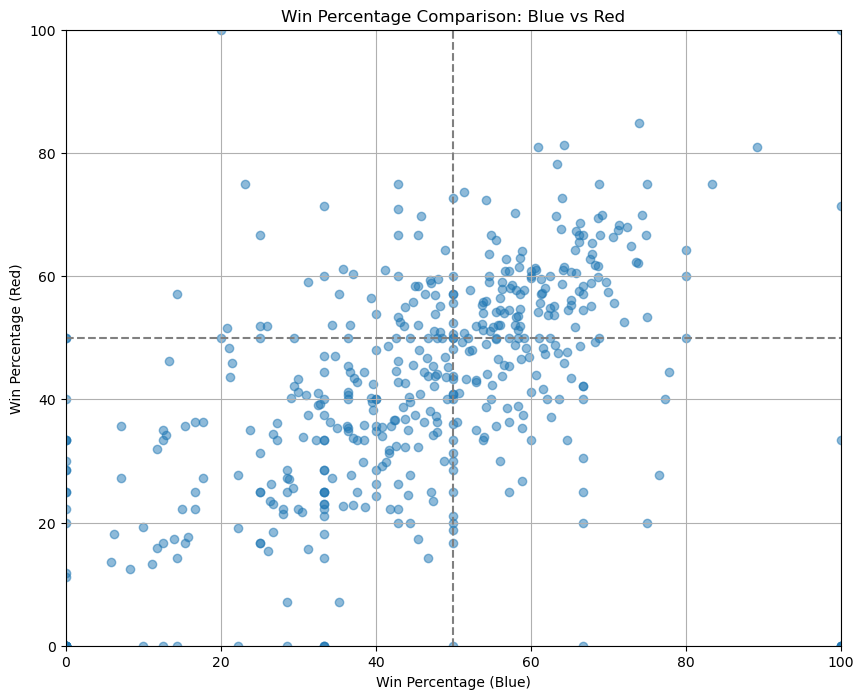

In [345]:
# Scatter plot of win percentages
plt.figure(figsize=(10, 8))
plt.scatter(blue_red_win_df['Win Percentage (Blue)'], blue_red_win_df['Win Percentage (Red)'], alpha=0.5)
plt.title('Win Percentage Comparison: Blue vs Red')
plt.xlabel('Win Percentage (Blue)')
plt.ylabel('Win Percentage (Red)')
plt.grid(True)
plt.axhline(50, color='grey', linestyle='--')
plt.axvline(50, color='grey', linestyle='--')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()

The scatter plot provides a visual comparison of win percentages for teams on both the blue and red sides. Here are a few observations from the plot:

### Quadrants

The dashed lines at 50% for both axes divide the plot into quadrants:
- Top Right Quadrant: Teams here have above-average win percentages on both sides.
- Top Left Quadrant: Teams here perform better on the red side than the blue side.
- Bottom Right Quadrant: Teams here perform better on the blue side than the red side.
- Bottom Left Quadrant: Teams here have below-average win percentages on both sides.

### Density

Most of the teams cluster around the 40-60% range for both sides, indicating that many teams have relatively balanced win percentages.

### Outliers

We don't see any outliers outside the 0-100% range

In [338]:
# Calculate the number of teams that have a higher win percentage on the blue side vs. the red side
blue_favored = blue_red_win_df[blue_red_win_df['Win Percentage (Blue)'] > blue_red_win_df['Win Percentage (Red)']].shape[0]
red_favored = blue_red_win_df[blue_red_win_df['Win Percentage (Red)'] > blue_red_win_df['Win Percentage (Blue)']].shape[0]
equal_performance = blue_red_win_df[blue_red_win_df['Win Percentage (Red)'] == blue_red_win_df['Win Percentage (Blue)']].shape[0]

blue_favored, red_favored, equal_performance

(276, 182, 26)